In [1]:
import numpy as np  # matrix/array functions
import pandas as pd  # loading and manipulating data
import matplotlib.pyplot as plt  # plotting
import seaborn as sns
from scipy.optimize import minimize  # finding optimal params in models
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

In [3]:
T = 100
K = 2
mu = [0.2, 0.8]

In [4]:
def softmax(beta=3):
    va = np.arange(0, 1.02, 0.02)
    vb = 1 - va
    x = 0.02

    pa = np.exp(beta * va) / (np.exp(beta * va) + np.exp(beta * vb))
    tmp = np.random.rand(51) < pa * (1 + x)
    data = tmp
    x_axis = va - vb
    return pa, data, x_axis

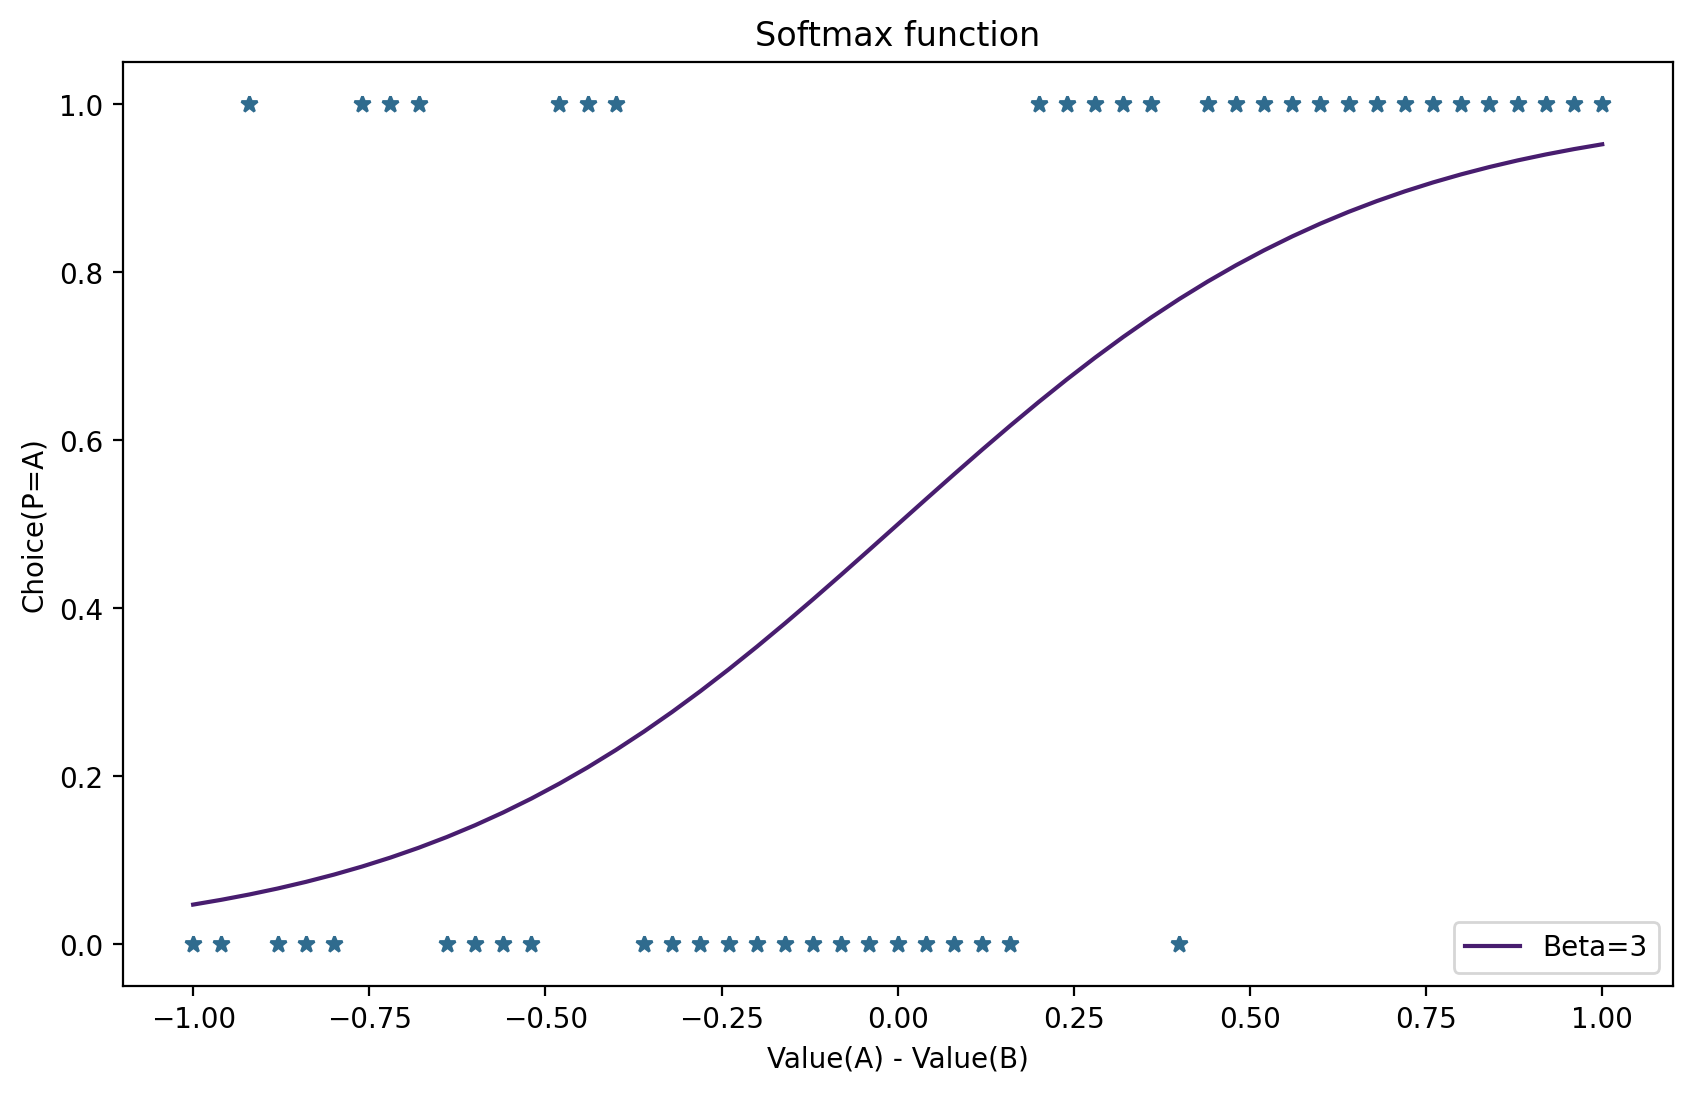

In [5]:
pa, data, x_axis = softmax()
beta = 3

plt.figure(figsize=(10, 6))
plt.plot(x_axis, pa, label="Beta=" + str(beta))
plt.plot(x_axis, data, marker="*", linestyle="None")

plt.title("Softmax function")
plt.ylabel("Choice(P=A)")
plt.xlabel("Value(A) - Value(B)")
plt.legend();

In [6]:
v = np.array([0.1, 0.75])

In [7]:
# Ridefiniamo la funzione softmax in modo tale che dipenda solo da V e beta.
def softmax(V, beta):
    p = np.exp(beta * V) / np.sum(np.exp(beta * V))
    return p

In [8]:
beta_values = np.linspace(0, 5, 100)

In [9]:
probability_array = np.zeros((2, 100))  # Initialize an array to store probabilities

for i, beta in enumerate(beta_values):
    probability_array[:, i] = softmax(v, beta)

In [10]:
probability_array.shape

(2, 100)

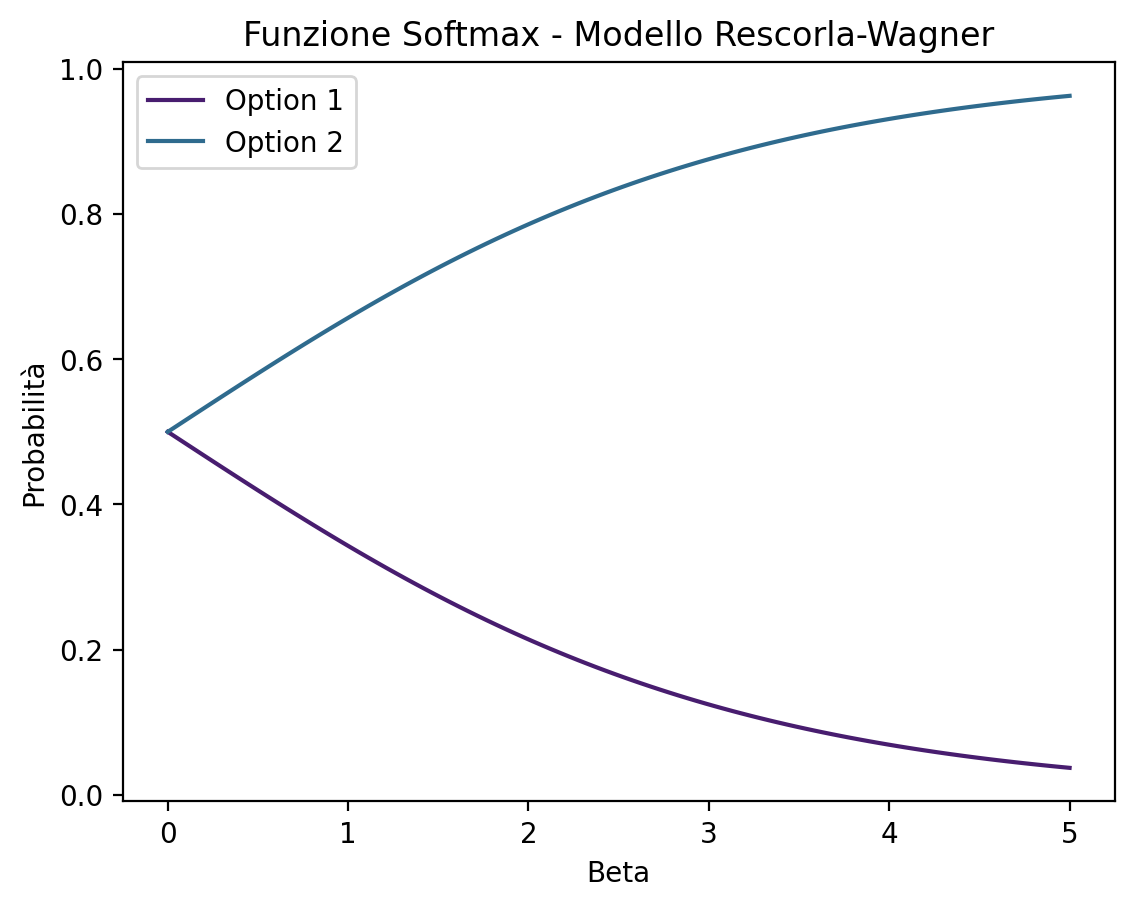

In [11]:
option_labels = ['Option 1', 'Option 2']

plt.figure()
for i in range(len(option_labels)):
    plt.plot(beta_values, probability_array[i], label=option_labels[i])

plt.xlabel("Beta")
plt.ylabel("Probabilità")
plt.title("Funzione Softmax - Modello Rescorla-Wagner")
plt.legend()
plt.show()

In [12]:
T = 100
K = 2
mu = [0.2, 0.8] # probabilità di ricompensa per la scelta delle due opzioni

In [13]:
def simulate_RescorlaWagner(params, T, mu):
    alpha, beta = params

    # Un array di zeri di lunghezza T; c = "choice" in [0, 1]; r = "reward".
    c = np.zeros((T), dtype=int)
    r = np.zeros((T), dtype=int)

    # Un array multidimensionale di zeri di dimensione 2xT
    V_stored = np.zeros((2, T), dtype=float)

    # Inizializza V per t == 0
    V = [0.5, 0.5]

    for t in range(T):
        # Salva i valori V per V_{t+1}
        V_stored[:, t] = V

        # Calcola le probabilità di scelta
        p0 = np.exp(beta * V[0]) / (np.exp(beta * V[0]) + np.exp(beta * V[1]))
        p1 = 1 - p0

        # Viene simulato un comportamento di scelta rumoroso in cui l'opzione 0
        # è scelta con probabilità p0, mentre l'opzione 1 è scelta con
        # probabilità 1-p0. 
        # `np.random.random_sample(1)` genera un valore casuale tra 0 e 1. `p0` 
        # rappresenta la probabilità di scegliere l'opzione 0. L'istruzione `if` 
        # verifica se il valore casuale generato è minore di p0. Se lo è, l'agente 
        # sceglie l'opzione 0 (`c[t] = 0`). Se il valore casuale non è minore di p0, 
        # l'agente sceglie l'opzione 1 (`c[t] = 1`).
        if np.random.random_sample(1) < p0:
            c[t] = 0
        else:
            c[t] = 1
       
        # Genera la ricompensa sulla base delle probabilità di ricompensa.
        # Il confronto `np.random.rand() < mu[c[t]]` determina se viene ricevuta una 
        # ricompensa in base alla probabilità definita per l'opzione scelta. Se il valore 
        # casuale generato è minore della probabilità di ricompensa (`mu`), allora viene 
        # ricevuta una ricompensa (`r[t]` viene impostato su `True`); in caso contrario, 
        # non viene ricevuta alcuna ricompensa (`r[t]` viene impostato su `False`).
        r[t] = np.random.rand() < mu[c[t]]

        # Aggiorna le aspettative di valore
        delta = r[t] - V[c[t]]
        V[c[t]] = V[c[t]] + alpha * delta

    return c, r, V_stored

In [14]:
c3, r3, V = simulate_RescorlaWagner([.1, 2.5], T=T, mu=mu)

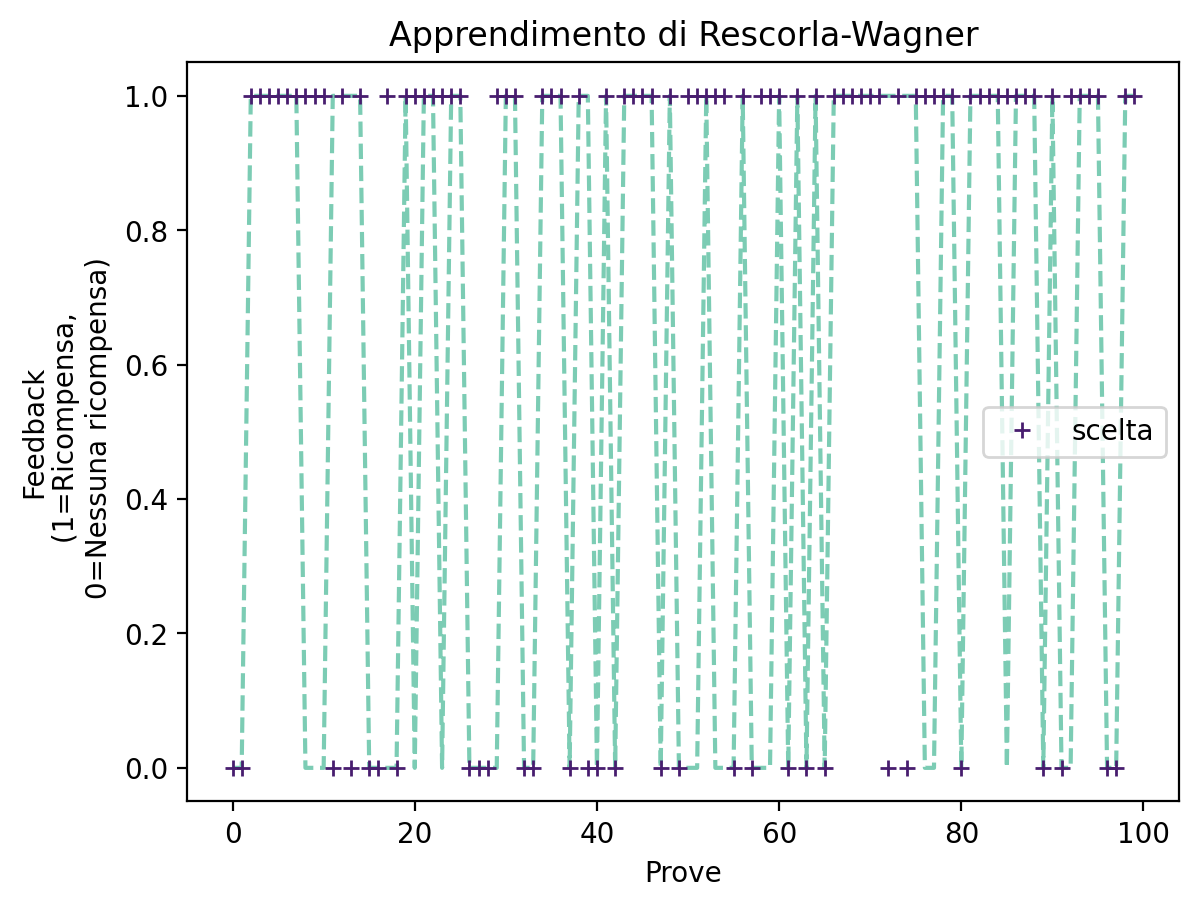

In [15]:
plt.figure()
plt.plot(range(T), r3, "C2--", alpha=0.6)
plt.plot(range(T), c3, "+", label="scelta")
plt.xlabel("Prove")
plt.ylabel("Feedback\n (1=Ricompensa,\n 0=Nessuna ricompensa)")
plt.title(f"Apprendimento di Rescorla-Wagner")
plt.legend();

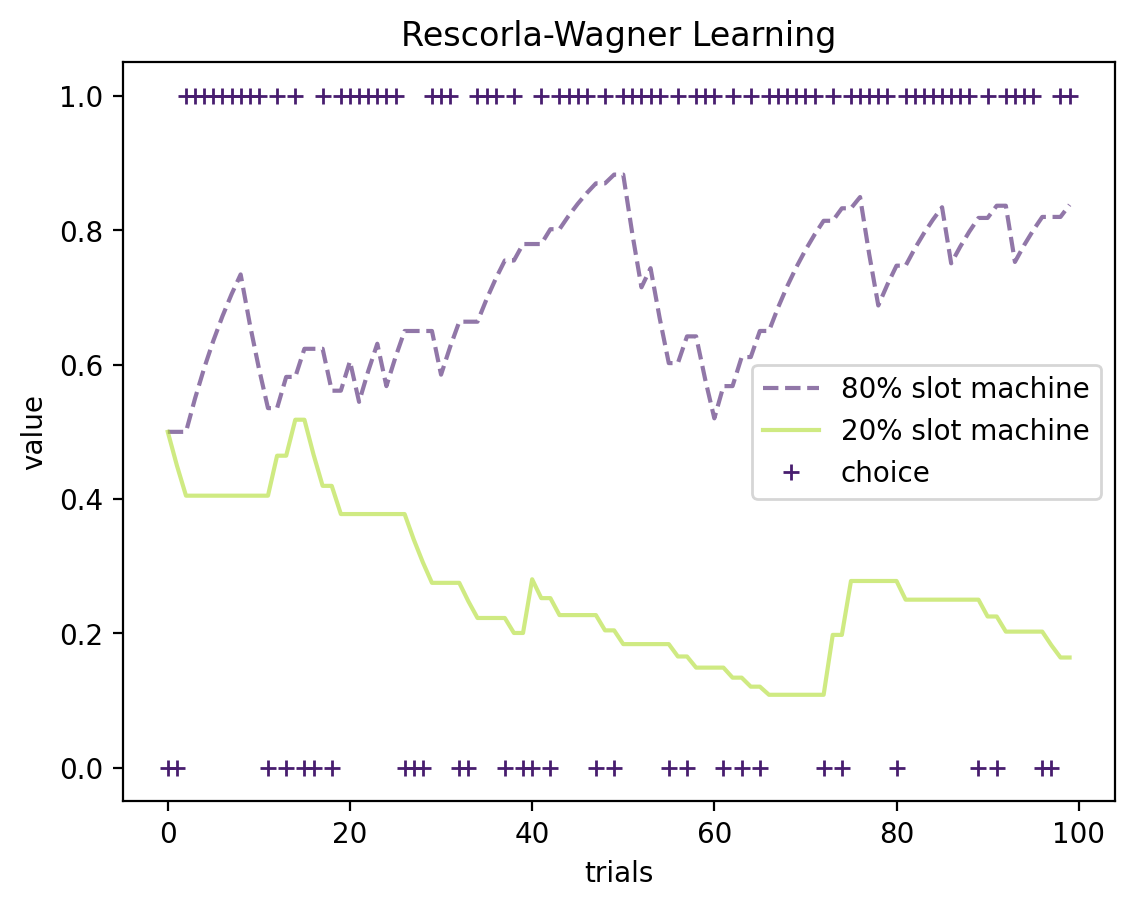

In [16]:
plt.figure()
plt.plot(range(T), V[1, :], "C0--", alpha=0.6, label="80% slot machine")
plt.plot(range(T), V[0, :], "C3-", alpha=0.6, label="20% slot machine")
plt.plot(range(T), c3, "C0+", label="choice")
plt.xlabel("trials")
plt.ylabel("value")
plt.title(f"Rescorla-Wagner Learning")
plt.legend();

In [17]:
def negll_RescorlaWagner(params, c, r):
    alpha, beta = params

    V = [0.5, 0.5]
    T = len(c)
    choiceProb = np.zeros((T), dtype=float)

    for t in range(T):
        # Calcola le probabilità di scelta per k = 2
        p0 = np.exp(beta * V[0]) / (np.exp(beta * V[0]) + np.exp(beta * V[1]))
        # "p" è una lista di probabilità di scelta per le due opzioni disponibili, in
        # cui p[0] rappresenta la probabilità di scegliere l'opzione 1 e p[1] rappresenta
        # la probabilità di scegliere l'opzione 2.
        p = [p0, 1 - p0]

        # La variabile "c[t]" indica l'opzione effettivamente scelta al tempo "t", che può
        # essere 0 o 1. Quindi "p[c[t]]" seleziona l'elemento corrispondente nell'elenco
        # delle probabilità di scelta. Ad esempio, se "c[t]" è uguale a 0, "p[c[t]]"
        # restituirà p[0], ovvero la probabilità di scegliere l'opzione 1. Allo stesso
        # modo, se "c[t]" è uguale a 1, "p[c[t]]" restituirà p[1], ovvero la probabilità
        # di scegliere l'opzione 2.
        choiceProb[t] = p[c[t]]

        # Aggiorniamo le aspettative di valore secondo la regola di Rescorla-Wagner.
        delta = r[t] - V[c[t]]
        V[c[t]] = V[c[t]] + alpha * delta

    # Una volta trovate le probabilità associate a ciascuna scelta, otteniamo il negativo
    # della log-verosimiglianza
    negLL = -np.sum(np.log(choiceProb))

    return negLL

In [18]:
# simulate choices from RW Model
alpha = 0.2
beta = 1.5
c4, r4, V2 = simulate_RescorlaWagner([alpha, beta], T=T, mu=[0.2, 0.8])

In [19]:
alpha_hat = 0.3
beta_hat = 2.5
negLL = negll_RescorlaWagner([alpha_hat, beta_hat], c4, r4)
print(alpha_hat, beta_hat, negLL)

0.3 2.5 66.29218809604724


In [20]:
alpha_hat = 0.2
beta_hat = 1.5
negLL = negll_RescorlaWagner([alpha_hat, beta_hat], c4, r4)
print(alpha_hat, beta_hat, negLL)

0.2 1.5 62.669268861256285


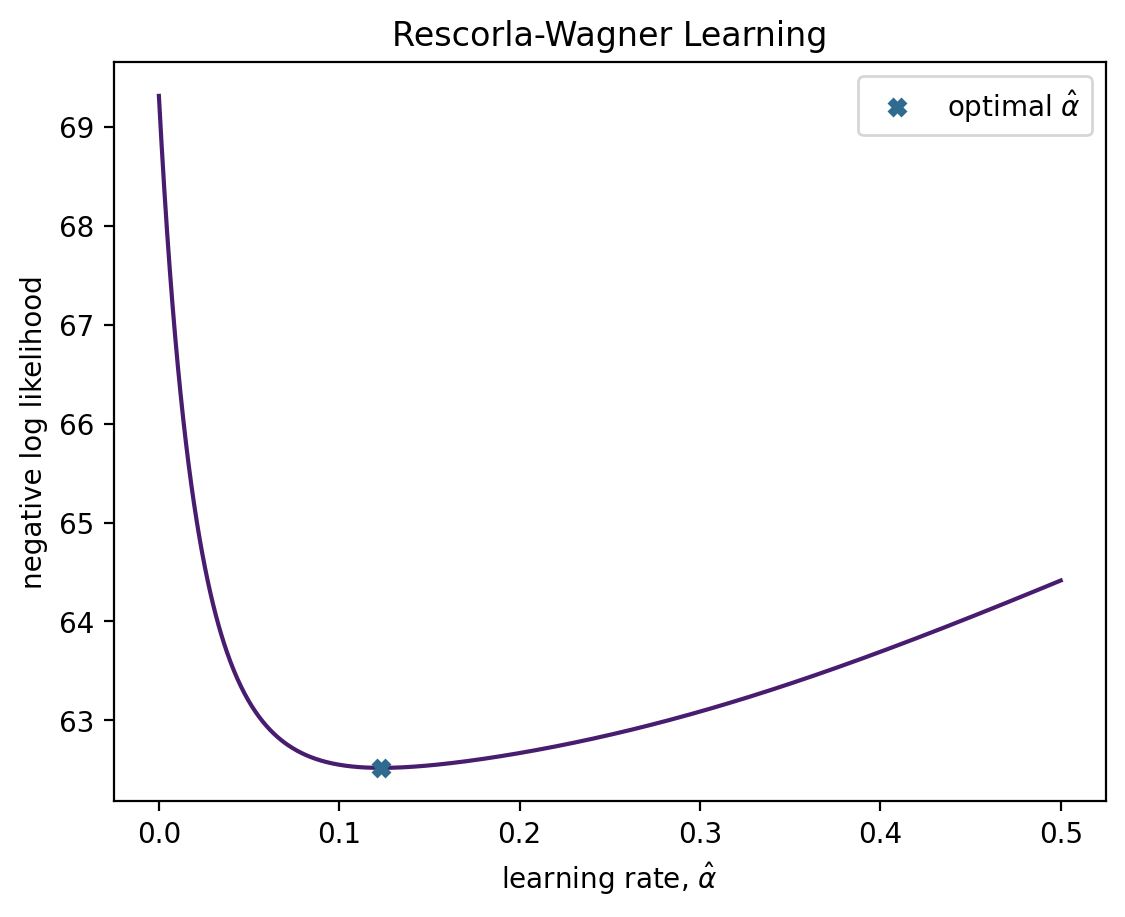

In [21]:
nLL = []
alpha_vals = np.linspace(0, 0.5, 1000)
for alpha_val in alpha_vals:
    nLL.append(negll_RescorlaWagner([alpha_val, beta], c4, r4))

plt.figure()
plt.plot(alpha_vals, nLL, "-")
plt.plot(
    alpha_vals[np.argmin(nLL)], nLL[np.argmin(nLL)], "X", label=r"optimal $\hat \alpha$"
)
plt.ylabel("negative log likelihood")
plt.xlabel(rf"learning rate, $\hat \alpha$")
plt.title(f"Rescorla-Wagner Learning")
plt.legend();

In [22]:
T = 250
mu = [0.2, 0.8]
NSUBJ = 500

In [23]:
def negll_RescorlaWagner(params, choices, outcomes):
    alpha, beta = params

    if np.isnan(alpha) or np.isnan(beta):  # check inputs
        return np.inf

    else:
        c, r = choices, outcomes

        T = len(c)
        V = [0.5, 0.5]  # Q at trial 0
        V_stored = np.zeros((2, T), dtype=float)
        choiceProb = np.zeros((T), dtype=float)

        for t in range(T):  # add comment
            # compute choice probabilities for k=2
            # use the softmax rule
            ev = np.exp(beta * np.array(V))
            sum_ev = np.sum(ev)
            p = ev / sum_ev

            # compute choice probability for actual choice
            choiceProb[t] = p[c[t]]

            # update values
            delta = r[t] - V[c[t]]
            V[c[t]] = V[c[t]] + alpha * delta

            # store Q_t+1
            V_stored[:, t] = V

        negLL = -np.sum(np.log(choiceProb))  # add comment

        return negLL

In [24]:
c, r, V = simulate_RescorlaWagner([0.15, 1.5], T=T, mu=mu)

init_guess = (0.1, 0.1)

# minimize neg LL
result = minimize(
    negll_RescorlaWagner,
    init_guess,
    (c, r),
    bounds=((0, 1), (0, 10)),
)
print(result.x)

[0.14651851 1.39323198]


In [25]:
df = pd.DataFrame(
    index=range(0, NSUBJ), columns=["true_alpha", "alpha", "true_beta", "beta"]
)

# loop through subjects
for index in range(NSUBJ):
    true_alpha = 0.95 * np.random.random()
    true_beta = 4.0 * np.random.random()

    c, r, V = simulate_RescorlaWagner([true_alpha, true_beta], T=250, mu=mu)

    init_guess = (0.2 * np.random.random(), 1.0 * np.random.random())
    # minimize neg LL
    param_fits = minimize(
        negll_RescorlaWagner,
        init_guess,
        (c, r),
        bounds=((0, 1), (0, 10)),
    )

    # store in dataframe
    df.at[index, "true_alpha"] = true_alpha
    df.at[index, "true_beta"] = true_beta
    df.at[index, "alpha"] = param_fits.x[0]
    df.at[index, "beta"] = param_fits.x[1]

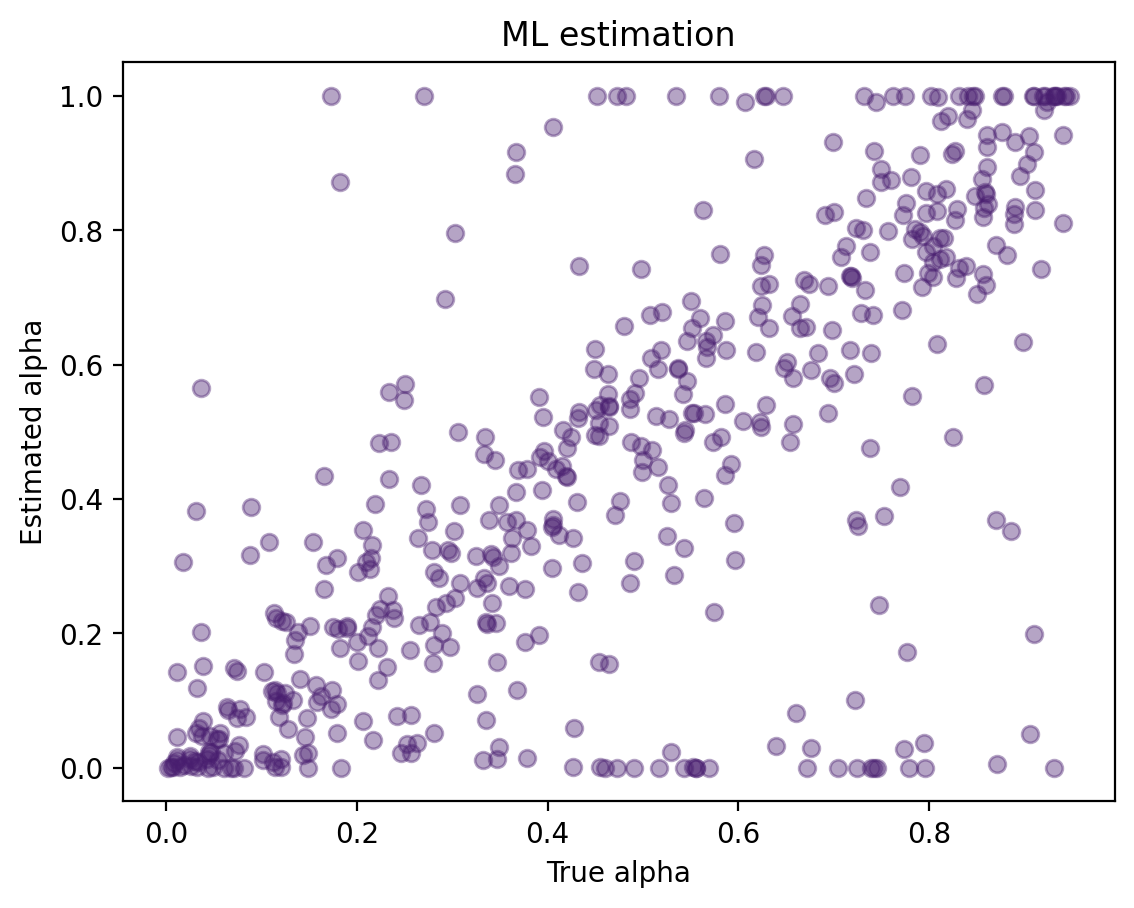

In [26]:
plt.figure()
plt.plot(df.true_alpha, df.alpha, "C0o", alpha=0.4)
plt.xlabel("True alpha")
plt.ylabel("Estimated alpha")
plt.title(f"ML estimation");

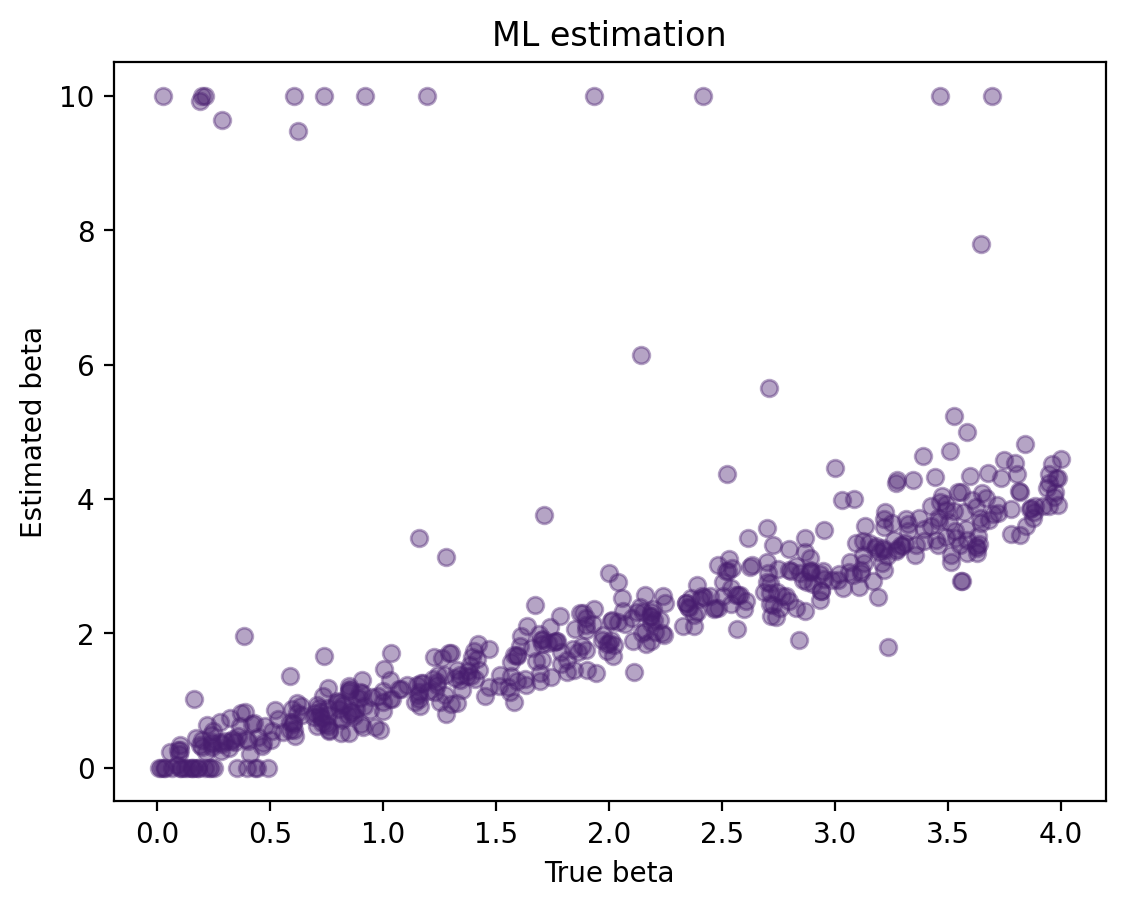

In [27]:
plt.figure()
plt.plot(df.true_beta, df.beta, "C0o", alpha=0.4)
plt.xlabel("True beta")
plt.ylabel("Estimated beta")
plt.title(f"ML estimation");

In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Sep 17 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

seaborn   : 0.12.2
arviz     : 0.16.0
matplotlib: 3.7.2
numpy     : 1.25.2
pandas    : 2.0.3

Watermark: 2.4.3

